In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
batch_size = 192

#Downloads datasets
image_size = (224, 224)
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = torchvision.datasets.Imagenette(root='./data', download=True, transform=transform) #Set download to true first time
class_names = dataset.classes

#Split for cross validation
test_size = len(dataset) // 6
train_size = len(dataset) - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)


In [3]:
#Defines class for a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, halving):
        super().__init__()

        #If halving is true, the feature size is cut in half and the out_channels is doubled
        out_channels = in_channels
        stride1 = 1
        stride2 = 1
        if halving:
            out_channels *= 2
            stride1 = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1), \
                                        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)) if halving else None

    def forward(self, x):
        #Keeps activation from previous layer to add as residual later
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        #Normal convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        #Adds residual
        x += identity
        out = F.relu(x)
        return out


#Defines Convolutional Neural Network
class Resnet(nn.Module):
    def __init__(self,):
        super().__init__()

        #Residual/Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=2, padding=2)

        self.res1 = ResidualBlock(in_channels=64, kernel_size=3, halving=False)
        self.res2 = ResidualBlock(in_channels=64, kernel_size=3, halving=False)

        self.res3 = ResidualBlock(in_channels=64, kernel_size=3, halving=True)
        self.res4 = ResidualBlock(in_channels=128, kernel_size=3, halving=False)

        self.res5 = ResidualBlock(in_channels=128, kernel_size=3, halving=True)
        self.res6 = ResidualBlock(in_channels=256, kernel_size=3, halving=False)

        self.res7 = ResidualBlock(in_channels=256, kernel_size=3, halving=True)
        self.res8 = ResidualBlock(in_channels=512, kernel_size=3, halving=False)

        self.pool2 = nn.AvgPool2d(kernel_size=7,stride=1)

        #Fully connected layers
        self.flatten = nn.Flatten()
        self.out = nn.Linear(in_features=512, out_features=10)


    def forward(self, x):
        #Residual/Convolutional layers with ReLU activation function
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.res1(x)
        x = self.res2(x)

        x = self.res3(x)
        x = self.res4(x)

        x = self.res5(x)
        x = self.res6(x)

        x = self.res7(x)
        x = self.res8(x)

        x = self.pool2(x)

        #Fully connected layer with ReLU activation
        x = self.flatten(x)
        out = F.relu(self.out(x))
        
        return out

In [4]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion):
    network.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    # Generate numpy arrays to save our training data and plot it
    save_every = 5
    batches = []
    losses = []
    accuracy = []
    batch_count_avg = 0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        batch_count_avg += 1
        loss.backward()
        optimizer.step()

        if batch_index % save_every == 0:
            avg_loss_across_batches = running_loss / batch_count_avg
            avg_acc_across_batches = (running_accuracy / batch_count_avg) * 100
            batches.append(batch_index)
            losses.append(avg_loss_across_batches)
            accuracy.append(avg_acc_across_batches)
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0
            batch_count_avg = 0

    return batches, losses, accuracy

    

#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):
    network.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()


    avg_loss_across_batches = running_loss / len(testloader)
    avg_accuracy_across_batches = (running_accuracy / len(testloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()

    return avg_loss_across_batches, avg_accuracy_across_batches
            

Epoch 1
Batch1, Loss: 2.331, Accuracy: 4.7%
Batch6, Loss: 2.100, Accuracy: 23.6%
Batch11, Loss: 1.934, Accuracy: 35.8%
Batch16, Loss: 1.642, Accuracy: 47.1%
Batch21, Loss: 1.614, Accuracy: 47.9%
Batch26, Loss: 1.601, Accuracy: 46.5%
Batch31, Loss: 1.450, Accuracy: 52.3%
Batch36, Loss: 1.338, Accuracy: 56.7%
Batch41, Loss: 1.323, Accuracy: 56.8%
Val Loss: 1.736, Val Accuracy: 41.1%
*****************************************



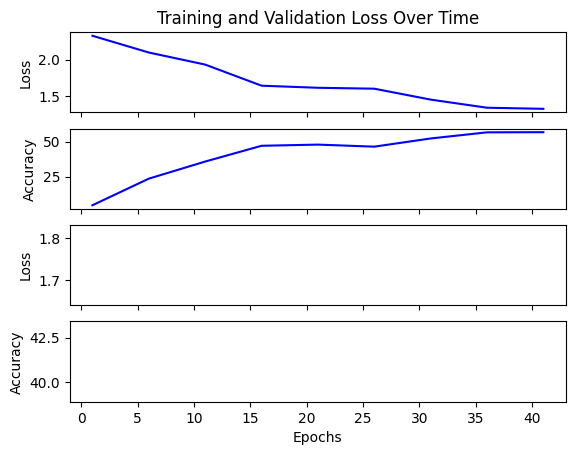

Epoch 2
Batch1, Loss: 1.290, Accuracy: 59.9%
Batch6, Loss: 1.261, Accuracy: 60.4%
Batch11, Loss: 1.256, Accuracy: 58.2%
Batch16, Loss: 1.152, Accuracy: 63.3%
Batch21, Loss: 1.188, Accuracy: 62.3%
Batch26, Loss: 1.038, Accuracy: 65.2%
Batch31, Loss: 1.133, Accuracy: 64.9%
Batch36, Loss: 1.084, Accuracy: 65.1%
Batch41, Loss: 1.022, Accuracy: 67.3%
Val Loss: 1.539, Val Accuracy: 48.1%
*****************************************



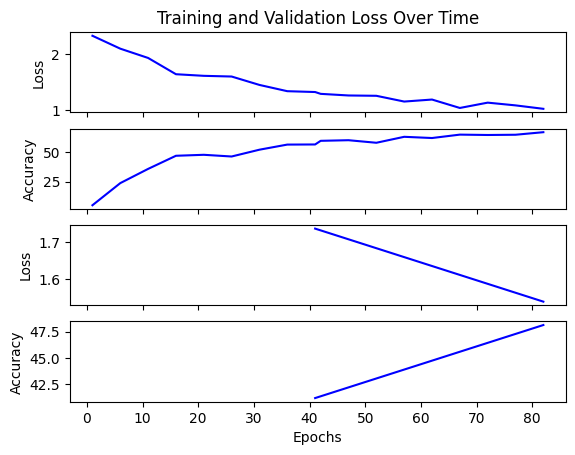

Epoch 3
Batch1, Loss: 1.054, Accuracy: 65.6%
Batch6, Loss: 0.996, Accuracy: 67.8%
Batch11, Loss: 0.905, Accuracy: 70.5%
Batch16, Loss: 0.968, Accuracy: 69.3%
Batch21, Loss: 0.929, Accuracy: 70.2%
Batch26, Loss: 0.893, Accuracy: 70.4%
Batch31, Loss: 0.851, Accuracy: 72.3%
Batch36, Loss: 0.882, Accuracy: 70.9%
Batch41, Loss: 0.865, Accuracy: 72.8%
Val Loss: 1.533, Val Accuracy: 50.6%
*****************************************



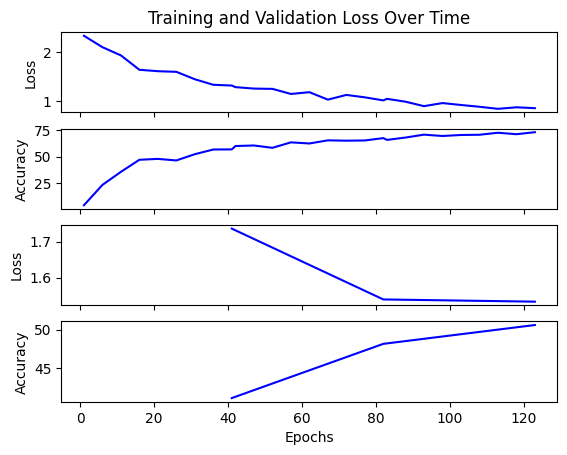

Epoch 4
Batch1, Loss: 0.729, Accuracy: 76.0%
Batch6, Loss: 0.786, Accuracy: 73.5%
Batch11, Loss: 0.771, Accuracy: 76.1%
Batch16, Loss: 0.800, Accuracy: 74.3%
Batch21, Loss: 0.762, Accuracy: 75.5%
Batch26, Loss: 0.766, Accuracy: 75.9%
Batch31, Loss: 0.707, Accuracy: 76.9%
Batch36, Loss: 0.780, Accuracy: 74.9%
Batch41, Loss: 0.710, Accuracy: 77.7%
Val Loss: 1.087, Val Accuracy: 59.7%
*****************************************



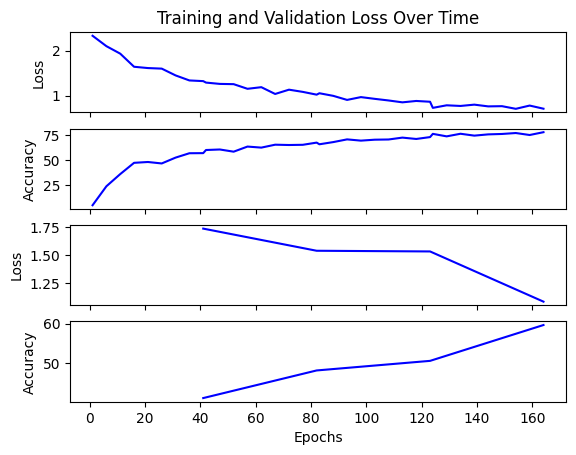

Epoch 5
Batch1, Loss: 0.542, Accuracy: 82.8%
Batch6, Loss: 0.673, Accuracy: 78.1%
Batch11, Loss: 0.651, Accuracy: 79.0%
Batch16, Loss: 0.590, Accuracy: 81.8%
Batch21, Loss: 0.581, Accuracy: 82.0%
Batch26, Loss: 0.537, Accuracy: 82.7%
Batch31, Loss: 0.603, Accuracy: 80.9%
Batch36, Loss: 0.597, Accuracy: 80.5%
Batch41, Loss: 0.664, Accuracy: 77.2%
Val Loss: 1.170, Val Accuracy: 60.4%
*****************************************



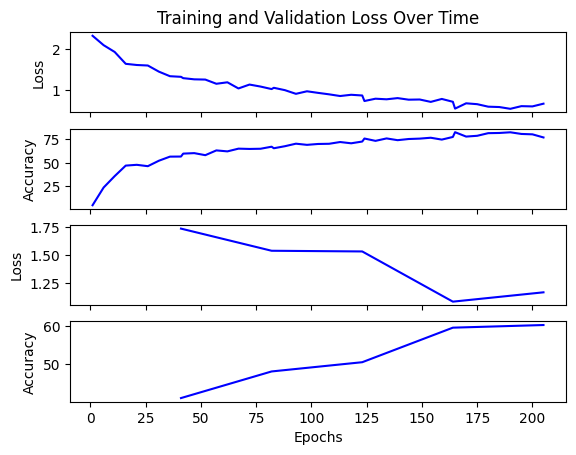

Epoch 6
Batch1, Loss: 0.360, Accuracy: 90.6%
Batch6, Loss: 0.518, Accuracy: 83.8%
Batch11, Loss: 0.470, Accuracy: 84.8%
Batch16, Loss: 0.411, Accuracy: 88.0%
Batch21, Loss: 0.429, Accuracy: 85.9%
Batch26, Loss: 0.401, Accuracy: 87.5%
Batch31, Loss: 0.437, Accuracy: 87.2%
Batch36, Loss: 0.389, Accuracy: 87.8%
Batch41, Loss: 0.398, Accuracy: 88.1%
Val Loss: 2.202, Val Accuracy: 46.9%
*****************************************



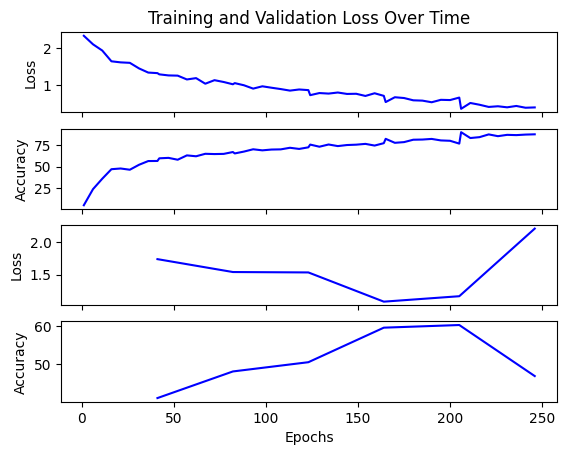

Epoch 7
Batch1, Loss: 0.318, Accuracy: 90.1%
Batch6, Loss: 0.411, Accuracy: 86.9%
Batch11, Loss: 0.375, Accuracy: 88.4%
Batch16, Loss: 0.317, Accuracy: 89.8%
Batch21, Loss: 0.312, Accuracy: 90.4%
Batch26, Loss: 0.300, Accuracy: 91.6%
Batch31, Loss: 0.273, Accuracy: 91.7%
Batch36, Loss: 0.271, Accuracy: 92.2%
Batch41, Loss: 0.233, Accuracy: 93.2%
Val Loss: 1.200, Val Accuracy: 59.3%
*****************************************



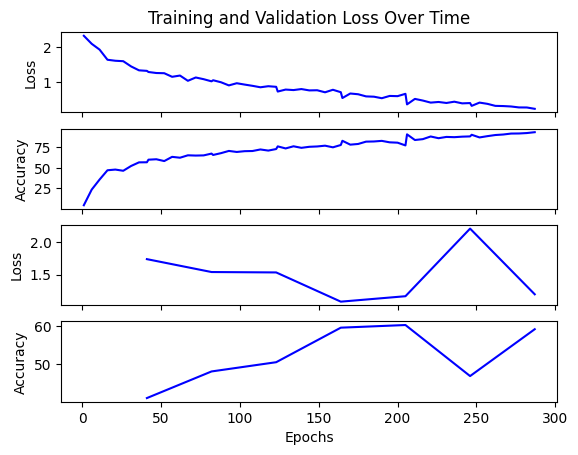

Epoch 8
Batch1, Loss: 0.205, Accuracy: 94.3%
Batch6, Loss: 0.264, Accuracy: 92.1%
Batch11, Loss: 0.236, Accuracy: 92.6%
Batch16, Loss: 0.237, Accuracy: 93.1%
Batch21, Loss: 0.241, Accuracy: 93.8%
Batch26, Loss: 0.211, Accuracy: 94.2%
Batch31, Loss: 0.185, Accuracy: 94.5%
Batch36, Loss: 0.183, Accuracy: 94.4%
Batch41, Loss: 0.179, Accuracy: 94.6%
Val Loss: 1.807, Val Accuracy: 52.9%
*****************************************



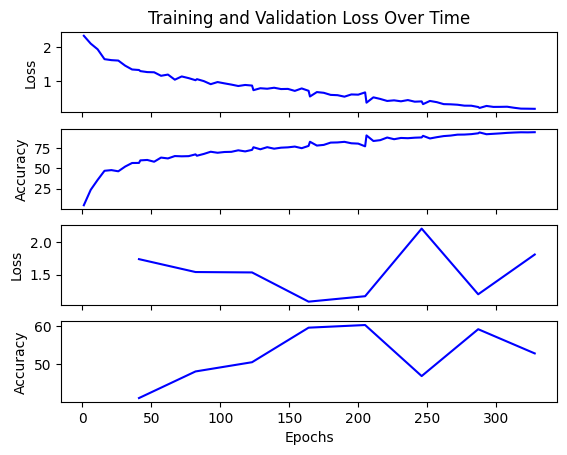

Saved batches_training to Resnet1\batches_training.npy
Saved losses_training to Resnet1\losses_training.npy
Saved accuracies_training to Resnet1\accuracies_training.npy
Saved batches_validation to Resnet1\batches_validation.npy
Saved losses_validation to Resnet1\losses_validation.npy
Saved accuracies_validation to Resnet1\accuracies_validation.npy


In [5]:
#Sets up CNN, optimizer, and loss function
resnet = Resnet()
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

batches_training = np.array([])
losses_training = np.array([])
accuracies_training  = np.array([])
batches_validation = np.array([])
losses_validation = np.array([])
accuracies_validation = np.array([])

fig = None

def new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation):
    fig, ax = plt.subplots(4, 1, sharex=True)
    ax[0].clear()
    ax[0].plot(batches_training, losses_training, label='Training Loss', color='blue')
    ax[0].set_ylabel('Loss')
    ax[0].relim()
    ax[0].autoscale_view()

    ax[1].clear()
    ax[1].plot(batches_training, accuracies_training, label='Training Accuracies', color='blue')
    ax[1].set_ylabel('Accuracy')
    ax[1].relim()
    ax[1].autoscale_view()

    ax[2].clear()
    ax[2].plot(batches_validation, losses_validation, label='Validation Loss', color='blue')
    ax[2].set_ylabel('Loss')
    ax[2].relim()
    ax[2].autoscale_view()

    ax[3].clear()
    ax[3].plot(batches_validation, accuracies_validation, label='Validation Accuracies', color='blue')
    ax[3].set_ylabel('Accuracy')
    ax[3].relim()
    ax[3].autoscale_view()
    
    ax[3].set_xlabel('Epochs')
    ax[0].set_title('Training and Validation Loss Over Time')

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.1)  # Adjust to control the update speed
    return fig

#Trains the CNN
num_epochs = 8
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    batches_toadd, losses_toadd, accuracy_toadd = train_epoch(resnet, optimizer, criterion)
    last_batch_num = 0 if len(batches_training) == 0 else batches_training[-1]
    batches_training = np.append(batches_training, (np.array(batches_toadd) + last_batch_num + 1))
    losses_training = np.append(losses_training, losses_toadd)
    accuracies_training = np.append(accuracies_training, accuracy_toadd)

    losses_toadd, accuracy_toadd = validate_epoch(resnet, criterion)
    batches_validation = np.append(batches_validation, batches_training[-1])
    losses_validation = np.append(losses_validation, losses_toadd)
    accuracies_validation = np.append(accuracies_validation, accuracy_toadd)

    #Plot
    if fig:
        plt.close(fig)
    fig = new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation)
    
plt.show()

# Save the loss data so that we can process/graph it later
folder_path = "Resnet1"
os.makedirs(folder_path, exist_ok=True)

to_save = {
    "batches_training": batches_training,
    "losses_training": losses_training,
    "accuracies_training": accuracies_training,
    "batches_validation": batches_validation,
    "losses_validation": losses_validation,
    "accuracies_validation": accuracies_validation
}

for name, array in to_save.items():
    file_path = os.path.join(folder_path, f"{name}.npy")
    np.save(file_path, array)
    print(f"Saved {name} to {file_path}")




In [6]:
#Verifies accuracy on test data set
total_correct = 0
total = 0
resnet.train(False)
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        total += len(outputs)
print(f"Accuracy {(total_correct/total) * 100}")

Accuracy 57.92141951837769


In [7]:
torch.save(resnet, 'DeepResNetParams.pth')

In [8]:
#Loads previously trained models
with torch.serialization.safe_globals([Resnet]):
    resnet = torch.load('DeepResNetParams.pth', weights_only=False)
resnet.to(device)
test_iter = iter(testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5877128].


True label: French horn
Guess label: French horn


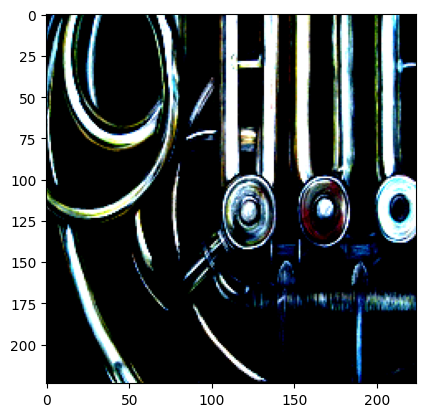

In [12]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
resnet.train(False)
guess_labels = resnet(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {class_names[true_labels[0]][0]}")
print(f"Guess label: {class_names[guess_label][0]}")
plt.imshow(np_img.transpose((1, 2, 0)))